# AlphaPept Test Runs and Visualization Examples

This notebooks is intended to show how a HeLa File can be processed.

## Download Test Data

In [1]:
import os
try:
    import wget
except ModuleNotFoundError:
    !pip install wget
    
FILE_DICT = {}
FILE_DICT['thermo_IRT.raw'] = 'https://datashare.biochem.mpg.de/s/GpXsATZtMwgQoQt/download'
FILE_DICT['IRT_fasta.fasta'] = 'https://datashare.biochem.mpg.de/s/p8Qu3KolzbSiCHH/download'

tmp_folder = os.path.join(os.getcwd(),'/temp')

if not os.path.isdir(tmp_folder):
    os.mkdir(tmp_folder)
    
for file in FILE_DICT:
    target = os.path.join(tmp_folder, file)
    if not os.path.isfile(target):
        wget.download(FILE_DICT[file], target)

## Test Run

In [2]:
from alphapept.settings import load_settings
settings = load_settings('default_settings.yaml')

settings['experiment']['file_paths'] =  [os.path.join(tmp_folder, 'thermo_IRT.raw')]
settings['fasta']['fasta_paths'] = [os.path.join(tmp_folder, 'IRT_fasta.fasta')]
    
import alphapept.interface

settings_ = alphapept.interface.run_complete_workflow(settings)

2020-12-14 14:44:50 INFO - Currently 119.65 GB of memory available.
2020-12-14 14:44:50 INFO - System information: uname_result(system='Windows', node='PCMANN338', release='10', version='10.0.18362', machine='AMD64', processor='Intel64 Family 6 Model 85 Stepping 4, GenuineIntel')
2020-12-14 14:44:50 INFO - Python version 3.8.6 | packaged by conda-forge | (default, Nov 27 2020, 18:58:29) [MSC v.1916 64 bit (AMD64)]
2020-12-14 14:44:50 INFO - Numba version 0.51.2
2020-12-14 14:44:50 INFO - Check for settings not completely implemented yet.
2020-12-14 14:44:50 INFO - Checking CPU settings.
2020-12-14 14:44:50 INFO - Setting number of processes to 24.
2020-12-14 14:44:50 INFO - Checking if files exist.
2020-12-14 14:44:50 INFO - Results path was not set. Setting to F:\temp\results.hdf
2020-12-14 14:44:50 INFO - Shortnames not set. Setting to filename.
2020-12-14 14:44:50 INFO - No database path set and save_db option checked. Using default path F:\temp\database.hdf
2020-12-14 14:44:50 INFO

## Basic file access

Files can be read via the alphapept.io class and displayed as pandas dataframe

In [3]:
import alphapept.io

_ = settings['experiment']['file_paths'][0]
base, ext = os.path.splitext(_)

ms_file = alphapept.io.MS_Data_File(base+'.ms_data.hdf')

print(ms_file.read())

df = ms_file.read(dataset_name='protein_fdr')

df.head()

['Raw', 'corrected_fragment_mzs', 'feature_table', 'features', 'first_search', 'ions', 'peptide_fdr', 'protein_fdr', 'second_search']


,abs_delta_m_ppm,b-H2O_hits,b-NH3_hits,b_hits,charge,db_idx,decoy,decoys_cum,decoys_cum_protein,delta_m,...,target,target_cum,target_cum_protein,target_precursor,target_protein,total_int,x_tandem,y-H2O_hits,y-NH3_hits,y_hits
0,1.881906,0,2,4,2,0,False,0,0,0.000782,...,True,7,1,True,True,40067735,30.914789,3,6,8
1,13.398595,0,1,2,2,2,False,0,0,0.004837,...,True,9,1,True,True,635629,18.091496,0,0,5
2,0.245930,4,1,5,2,9,False,0,0,-0.000090,...,True,1,1,True,True,21819864,41.003103,5,0,12
3,17.014830,5,0,5,2,10,False,0,0,0.008121,...,True,3,1,True,True,6383724,37.459423,2,4,11
4,30.018059,2,1,5,2,13,False,0,0,0.013741,...,True,2,1,True,True,12946349,40.650891,9,0,12


## MS2 Spectrum

Visualize PSMS

 Plotting PSMS for LGGNEQVTR_2


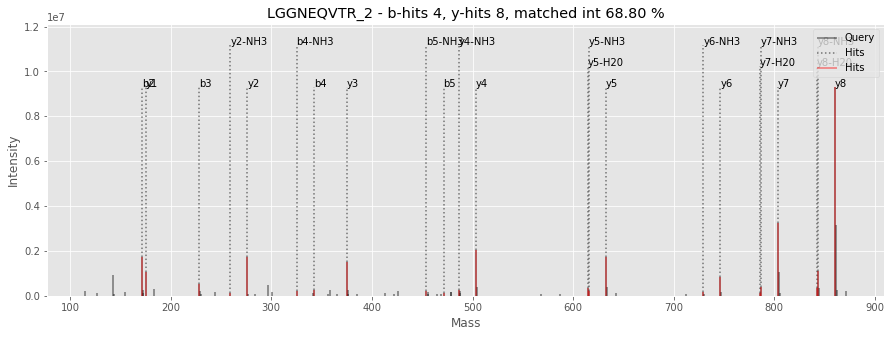

 Plotting PSMS for YILAGVENSK_2


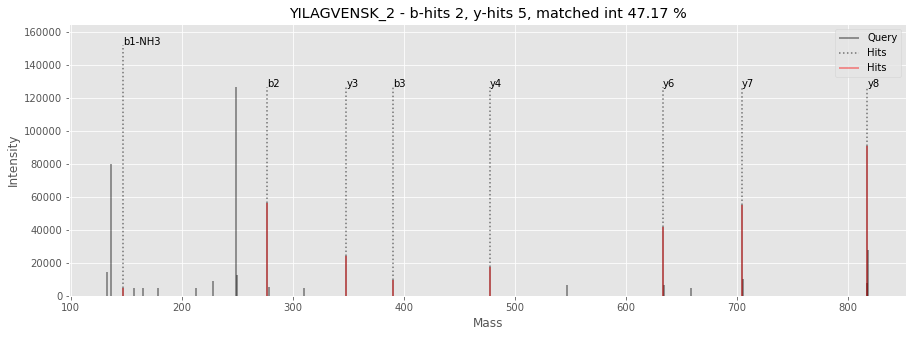

 Plotting PSMS for GAGSSEPVTGLDAK_2


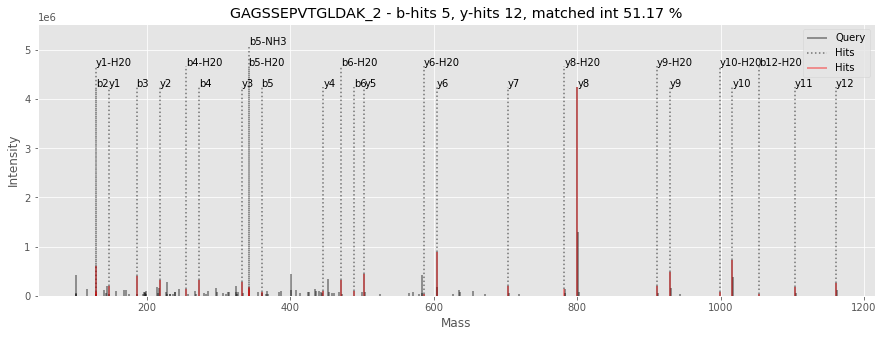

In [4]:
import matplotlib.pyplot as plt

def plot_psms(precursor, ms_file):

    df = ms_file.read(dataset_name='protein_fdr')
    
    ion_dict = {}
    ion_dict[0] = ''
    ion_dict[1] = '-H20'
    ion_dict[2] = '-NH3'

    spectrum = df[df['precursor'] == precursor].iloc[0]
    start = spectrum['ion_idx']
    end = spectrum['n_ions'] + start

    query_data = ms_file.read_DDA_query_data()
    ions = ms_file.read(dataset_name="ions")

    ion = [('b'+str(int(_))).replace('b-','y') for _ in ions.iloc[start:end]['ion_index']]
    losses = [ion_dict[int(_)] for _ in ions.iloc[start:end]['ion_type']]
    ion = [a+b for a,b in zip(ion, losses)]
    ints = ions.iloc[start:end]['ion_int'].astype('int').values
    masses = ions.iloc[start:end]['ion_mass'].astype('float').values
    ion_type = ions.iloc[start:end]['ion_type'].abs().values

    query_idx = spectrum['raw_idx']

    query_indices = query_data["indices_ms2"]
    query_bounds = query_data['bounds']
    query_charges = query_data['charge2']
    query_frags = query_data['mass_list_ms2']
    query_ints = query_data['int_list_ms2']

    query_idx_start = query_indices[query_idx]
    query_idx_end = query_indices[query_idx + 1]
    query_frag = query_frags[query_idx_start:query_idx_end]
    query_int = query_ints[query_idx_start:query_idx_end]

    ax = plt.figure(figsize=(15, 5))

    plt.vlines(query_frag, 0, query_int, "k", label="Query", alpha=0.5)

    plt.vlines(masses, ints, max(query_int)*(1+0.1*ion_type), "k", label="Hits", alpha=0.5, linestyle=':')

    plt.vlines(masses, 0, ints, "r", label="Hits", alpha=0.5)

    for i in range(len(masses)):
        plt.text(masses[i], (1+0.1*ion_type[i])*max(query_int), ion[i])

    figure_title = f"{spectrum['precursor']} - b-hits {spectrum['b_hits']}, y-hits {spectrum['y_hits']}, matched int {spectrum['matched_int_ratio']*100:.2f} %"

    plt.xlabel("Mass")
    plt.ylabel('Intensity')
    plt.ylim([0, (1+0.1*max(ion_type)+0.1)*max(query_int)])
    plt.legend()
    plt.title(figure_title)
    plt.show()
    
    
for index in range(3):
    precursor = df['precursor'].iloc[index]
    print(f" Plotting PSMS for {precursor}")
    plot_psms(precursor, ms_file)

## MS1

Visualize Feature..